载入实验需要的 python 包：

In [1]:
import os
from PIL import Image
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import re

from nltk.corpus import stopwords
import string
from transformers import BertModel,BertTokenizer

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.utils.data.dataset import random_split

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

from transformers import ViTModel

from torchvision import transforms
from torchvision.ops import sigmoid_focal_loss

from tqdm import tqdm

设置种子：

In [2]:
seed = 622

## 数据预处理

#### 读取数据

In [3]:
def load_data(data_dir, train_file):
    # 存储训练集数据和标签
    dataset = []
    
    # 读取 train.txt 文件
    train_path = os.path.join(data_dir, train_file)
    with open(train_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            guide, tag = line.strip().split(',')
            
            # 构造文件路径
            img_path = os.path.join(data_dir, "data", f"{guide}.jpg")
            txt_path = os.path.join(data_dir, "data",f"{guide}.txt")
            
            # 加载图片和文本数据
            if os.path.exists(img_path) and os.path.exists(txt_path):
                # 读取图片
                img = Image.open(img_path).convert('RGB')
                # 读取文本
                with open(txt_path, 'r' ,encoding='utf-8', errors='replace') as txt_file:
                    text = txt_file.read()
                # 添加到数据集
                dataset.append({
                    'guide': guide,
                    'image': img,
                    'text': text,
                    'tag': tag
                })
    return dataset

In [4]:
data_dir = "Data"
train_file = "train.txt"
dataset = load_data(data_dir, train_file)

df = pd.DataFrame(dataset)
print(df.head())

  guide                                              image  \
0  4597  <PIL.Image.Image image mode=RGB size=598x303 a...   
1    26  <PIL.Image.Image image mode=RGB size=600x450 a...   
2  4383  <PIL.Image.Image image mode=RGB size=599x337 a...   
3   212  <PIL.Image.Image image mode=RGB size=600x923 a...   
4  2626  <PIL.Image.Image image mode=RGB size=600x800 a...   

                                                text       tag  
0  RT @AmitSwami77: The conspirators have an evil...  negative  
1  Waxwing trills, Chickadees calling "here sweet...   neutral  
2  @NYSE is looking a little despondent today...?...  negative  
3  FERVENT | S,M,L | 140k free PLASTIC CLIP, keyc...  positive  
4  Nice day chilling in the park yesterday reliev...  positive  


#### 清洗数据

In [5]:
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE) # 去除URL
    text = re.sub(r'@\w+', '', text)    # 去除@用户
    text = re.sub(r'\bRT\b', '', text)  # 去除RT转发标记
    text = re.sub(r'[^\w\s]', '', text) # 去除特殊字符和表情符号
    text = text.strip()                 # 去除多余空格
    return text

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', cache_dir='./bert_model/')
stop_words = set(stopwords.words('english'))    # 英语停用词列表
punctuation_table = str.maketrans('', '', string.punctuation)   # 翻译表，将所有标点符号替换为空字符

def preprocess_text_for_w2v(text):
    clean_text(text)
    if not isinstance(text, str):
        return []
    text = text.lower().translate(punctuation_table)
    tokens = tokenizer.tokenize(text)  
    return [token for token in tokens if token.isalpha() and token not in stop_words] 

In [7]:
df['tokens'] = df['text'].apply(preprocess_text_for_w2v)

#### 查看数据分布

In [8]:
df['text_length'] = df['tokens'].apply(len)
max_length = df['text_length'].max()
print(f"最大文本长度: {max_length}")
print("文本长度分布:")
print(df['text_length'].value_counts().sort_index())

df.drop(columns=['text_length'], inplace=True)

最大文本长度: 20
文本长度分布:
text_length
0      12
1      55
2     113
3     142
4     213
5     298
6     314
7     352
8     384
9     398
10    441
11    366
12    315
13    253
14    160
15    110
16     40
17     17
18     11
19      3
20      3
Name: count, dtype: int64


In [9]:
tag_distribution = df['tag'].value_counts()
print(tag_distribution)

tag
positive    2388
negative    1193
neutral      419
Name: count, dtype: int64


#### 标签编码

In [10]:
label_encoder = LabelEncoder()

# 直接对 DataFrame 的 target 列进行编码
df['tag_encoded'] = label_encoder.fit_transform(df['tag'])

# 查看结果
print(df[['tag', 'tag_encoded']].head())

        tag  tag_encoded
0  negative            0
1   neutral            1
2  negative            0
3  positive            2
4  positive            2


#### Dataset 类

In [47]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 使用ImageNet的均值和标准差
])

In [48]:
class SummarizationDataset(Dataset):
    def __init__(self, df, image_col='image', text_col='text',target_col='tag', max_len=20, transform=None, tokenizer=None):
        self.df = df
        self.images = df[image_col].tolist()
        self.texts = df[text_col].tolist()
        self.labels = df[target_col].tolist()
        self.max_len = max_len
        
        self.transform = transform
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        
        text_to_tokenize = ' '.join(self.texts[idx])
        encoded_inputs = tokenizer(
            text_to_tokenize,             
            max_length=20,             
            padding='max_length',       
            truncation=True,            
            return_tensors="pt"         
        )   

        return {
            'image': image,
            'input_ids': encoded_inputs['input_ids'].squeeze(0),
            'attention_mask': encoded_inputs['attention_mask'].squeeze(0),
            'label': torch.tensor(self.labels[idx], dtype=torch.float)
        }

In [49]:
dataset = SummarizationDataset(df, image_col='image', text_col='tokens', target_col='tag_encoded', transform=transform, tokenizer=tokenizer)

In [14]:
print(dataset[3])

{'image': tensor([[[ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
         [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
         [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
         ...,
         [-1.6555, -1.6555, -1.6555,  ..., -1.6555, -1.6555, -1.6555],
         [-1.6555, -1.6555, -1.6555,  ..., -1.6555, -1.6555, -1.6555],
         [-1.6555, -1.6555, -1.6555,  ..., -1.6555, -1.6555, -1.6555]],

        [[ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
         [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
         [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
         ...,
         [-1.5630, -1.5630, -1.5630,  ..., -1.5630, -1.5630, -1.5630],
         [-1.5630, -1.5630, -1.5630,  ..., -1.5630, -1.5630, -1.5630],
         [-1.5630, -1.5630, -1.5630,  ..., -1.5630, -1.5630, -1.5630]],

        [[ 2.6400,  2.6400,  2.6400,  ...,  2.6400,  2.6400,  2.6400],
         [ 2.6400,  2.6400,  2.6400

## 模型搭建

### ResNet

In [15]:
# 残差块
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels,dropout_prob=0.5, stride=1, downsample=None):
        super(ResNetBlock, self).__init__()     # 调用父类方法

        self.residual = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),

            nn.ReLU(inplace=True),
            nn.Dropout(dropout_prob),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),

            nn.Dropout(dropout_prob),
        )

        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)


    def forward(self, x):
        identity = x
        out = self.residual(x) 
        if self.downsample:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out) 
        return out

In [16]:
class ResNet(nn.Module):
    def __init__(self, block, layers, feature_dim=512, dropout_prob=0.5):
        # layers: 列表，每个block的数量
        super(ResNet, self).__init__()

        self.in_channels = 64

        self.initial_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.layer1 = self.make_layer(block, 64, layers[0], dropout_prob)
        self.layer2 = self.make_layer(block, 128, layers[1], dropout_prob=dropout_prob, stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], dropout_prob=dropout_prob, stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], dropout_prob=dropout_prob, stride=2)

        self.final_layers = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(1),
            nn.Linear(512, feature_dim)
            # nn.Linear(512, num_classes)
        )


    def make_layer(self, block, out_channels, num_blocks, dropout_prob=0.5, stride=1):
        # 下采样
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

        # 构建层，每个层包含多个残差块
        layers = []

        # 第一个残差块，（也许）需要下采样
        layers.append(block(self.in_channels, out_channels, dropout_prob, stride, downsample))
        self.in_channels = out_channels
        # 后num_blocks-1个残差块
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels, dropout_prob ))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial_layers(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.final_layers(x)
        return x


### Transformer-Encoder

In [17]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # 位置索引数组：[max_len, 1]

        # 分母项
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        # 生成正余弦位置编码
        pe[:, 0::2] = torch.sin(position * div_term)  # 偶数使用sin
        pe[:, 1::2] = torch.cos(position * div_term)  # 奇数使用cos
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]

        # 将pe注册为模型的缓冲区，在训练和推理时不会作为参数更新，但可以通过模型保存和加载。
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        seq_len = x.size(1) # x: [batch_size, seq_len, d_model]
        x = x + self.pe[:, :seq_len, :] # 广播
        return x

In [18]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, nhead, dropout=0.1):
        super(MultiHeadAttention, self).__init__()

        assert d_model % nhead == 0, "d_model 必须能被 nhead 整除"
        self.d_model = d_model
        self.nhead = nhead
        self.d_k = d_model // nhead  # 每个头的维度

        # Q, K, V 的投影层，用于将 query, key, value 投影到高维空间
        # [batch_size, seq_len, d_model]
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)

        # 将多头输出合并后再投影回原始维度
        self.fc_out = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
  
        B, Q_len, _ = query.size()
        B, K_len, _ = key.size()
        B, V_len, _ = value.size()

        # 线性变换
        # [batch_size, seq_len, d_model] 
        Q = self.w_q(query) 
        K = self.w_k(key)    
        V = self.w_v(value)  

        # 拆分多头
        Q = Q.view(B, Q_len, self.nhead, self.d_k).transpose(1, 2)  # [B, nhead, Q_len, d_k]
        K = K.view(B, K_len, self.nhead, self.d_k).transpose(1, 2)  # [B, nhead, K_len, d_k]
        V = V.view(B, V_len, self.nhead, self.d_k).transpose(1, 2)  # [B, nhead, V_len, d_k]

        # 计算 Scaled Dot-Product Attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # 应用 mask
        # 保证 pad 或 decoder 中不可见的 token 不参与 attention
        if mask is not None:
            if mask.dim() == 2:
                mask = mask.unsqueeze(1).unsqueeze(2)   # [B, K_len] -> [B, 1, 1, K_len]
            elif mask.dim() == 3:
                mask = mask.unsqueeze(1)                # [B, Q_len, K_len] -> [B, 1, Q_len, K_len]
            
            scores = scores.masked_fill(mask == 0, float('-inf'))   # 将 mask 为 0 的位置填充为负无穷大 ，在 softmax 中变为 0

        # 计算注意力权重
        attn = torch.softmax(scores, dim=-1)
        attn = self.dropout(attn)

        # 加权求和
        out = torch.matmul(attn, V)  # [B, nhead, Q_len, d_k]

        # 合并多头
        out = out.transpose(1, 2).contiguous().view(B, Q_len, self.d_model)

        # 输出
        # 原始维度[batch_size, Q_len, d_model]
        out = self.fc_out(out)
        return out

In [19]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, dim_feedforward, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, dim_feedforward)
        self.fc2 = nn.Linear(dim_feedforward, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x) # 增加网络宽度以捕获更复杂的特征模式
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [20]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = PositionwiseFeedForward(d_model, dim_feedforward, dropout=dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask=None):
        # 注意力机制
        attn_out = self.self_attn(src, src, src, mask=src_mask)
        out1 = self.norm1(src + self.dropout(attn_out))
        
        # 前馈网络
        out2 = self.linear1(out1)
        out = self.norm2(out1 + self.dropout(out2)) # 残差连接
        
        return out

In [21]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_layers, dim_feedforward, dropout=0.1, max_len=512):
        super(Encoder, self).__init__()
        self.embed_tokens = nn.Embedding(vocab_size, d_model)
        self.pos_emb = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask=None):
        # src: [batch_size, src_len]

        x = self.embed_tokens(src)  # [batch_size, src_len, d_model]
        x = self.pos_emb(x) # 位置编码层，为嵌入向量引入位置信息
        x = self.dropout(x)

        # encoder 层
        for layer in self.layers:
            x = layer(x, src_mask=src_mask)
        return x

### 交叉注意力

In [22]:
class CrossModalAttention(nn.Module):
    def __init__(self, d_model, nhead, dropout=0.1):
        super(CrossModalAttention, self).__init__()

        self.mha = MultiHeadAttention(d_model, nhead, dropout=dropout)
  
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, img_feats, txt_feats, mask=None):
        # 图像特征做 query，文本特征做 key/value
        out = self.mha(query=img_feats, key=txt_feats, value=txt_feats, mask=mask)

        # 残差 + LayerNorm
        out = self.norm(img_feats + self.dropout(out))
        return out

In [23]:
class DualCrossModalAttention(nn.Module):
    def __init__(self, MultiHeadAttnClass=None, d_model=512, nhead=8, dropout=0.1):
        super(DualCrossModalAttention, self).__init__()
        
        # 图像 -> 查询文本
        self.cross_attn_img2txt = MultiHeadAttnClass(d_model, nhead, dropout=dropout)
        # 文本 -> 查询图像
        self.cross_attn_txt2img = MultiHeadAttnClass(d_model, nhead, dropout=dropout)
        
        # 层归一化
        self.norm_img = nn.LayerNorm(d_model)
        self.norm_txt = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, img_feats, txt_feats, mask_txt=None):
        img2txt_out = self.cross_attn_img2txt(query=img_feats, key=txt_feats, value=txt_feats, mask=mask_txt)
        out_img = self.norm_img(img_feats + self.dropout(img2txt_out))

        txt2img_out = self.cross_attn_txt2img(query=txt_feats, key=out_img, value=out_img,)
        out_txt = self.norm_txt(txt_feats + self.dropout(txt2img_out))

        return out_img, out_txt

### 多模态模型

In [24]:
class MultiModalModel_self(nn.Module):
    def __init__(self,
                 image_model: nn.Module,
                 text_model: nn.Module,
                 d_model=512,
                 nhead=8,
                 dropout=0.1,
                 num_classes=3):
        super(MultiModalModel_self, self).__init__()

        self.image_model = image_model     
        self.text_model = text_model      
        self.cross_attn = CrossModalAttention(d_model, nhead, dropout)
        self.dual_cross_attn = DualCrossModalAttention(MultiHeadAttnClass=MultiHeadAttention, d_model=d_model, nhead=nhead, dropout=dropout)
        self.fc = nn.Linear(d_model, num_classes)
        self.classifier = nn.Linear(d_model*2, num_classes)

    def forward(self, images, text_ids, mask):
        # 图像特征 => [B, 1, d_model]
        img_feats = self.image_model(images)
        if img_feats.dim() == 2:
            img_feats = img_feats.unsqueeze(1)
    
        # 文本特征 => [B, txt_len, d_model]
        txt_feats = self.text_model(text_ids, src_mask=mask)
    
        #### 特征拼接 ####

        # # 1)直接拼接
        # fused_feats = torch.cat([img_feats, txt_feats], dim=1)  # [B, 1 + txt_len, d_model]
        # fused_feats = fused_feats.mean(dim=1)  # 平均池化
        # logits = self.fc(fused_feats)


        # # 2)交叉注意力拼接
        # fused_img_feats = self.cross_attn(img_feats, txt_feats, mask)  # [B, 1, d_model]
        # fused_img_feats = fused_img_feats.squeeze(1)
        # logits = self.fc(fused_img_feats)

        # 3)双向交叉注意力拼接
        # out_img => [B, img_len, d_model]
        # out_txt => [B, txt_len, d_model]
        out_img, out_txt = self.dual_cross_attn(img_feats, txt_feats, mask_txt=mask)

        fused_img = out_img.mean(dim=1)
        fused_txt = out_txt.mean(dim=1) 

        fused = torch.cat([fused_img, fused_txt], dim=-1)  
        logits = self.classifier(fused)       
        
        return logits

## 预训练模型

### 图片处理

In [25]:
class PretrainedViTExtractor(nn.Module):
    def __init__(self, feature_dim=512, pretrained_path='./vit_model'):
        super().__init__()
        self.vit = ViTModel.from_pretrained(pretrained_path)
        self.fc = nn.Linear(768, feature_dim) 

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        pooled = outputs.pooler_output
        feats = self.fc(pooled)
        return feats

### 文本处理

In [51]:
class BertTextEncoder(nn.Module):
    def __init__(self, feature_dim=768, freeze_bert=False, pretrained_model_path='./bert_model1/'):
        super(BertTextEncoder, self).__init__()

        self.bert = BertModel.from_pretrained(pretrained_model_path)
        
        # # 对部分层 freeze
        # if freeze_bert:
        #     for name, param in self.bert.named_parameters():
        #         # if  "encoder.layer.11." not in name:
        #         param.requires_grad = False
        
        self.proj = nn.Linear(768, feature_dim)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        outputs = self.bert(
            input_ids=input_ids, 
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        
        last_hidden_state = outputs.last_hidden_state       # [B, seq_len, 768]
        last_hidden_state = self.proj(last_hidden_state)    # [B, seq_len, feature_dim]

        return last_hidden_state

### 多模态模型

In [27]:
class MultiModalModel_pretrain(nn.Module):
    def __init__(self, image_model, text_model, d_model=512,nhead = 8, dropout=0.1, num_classes=3):
        super(MultiModalModel_pretrain, self).__init__()
        self.image_model = image_model
        self.text_model = text_model

        self.cross_attn = CrossModalAttention(d_model, nhead, dropout)
        self.dual_cross_attn = DualCrossModalAttention(MultiHeadAttnClass=MultiHeadAttention, d_model=d_model, nhead=nhead, dropout=dropout)

        self.classifier = nn.Linear(d_model*2, num_classes)

        self.fusion = nn.Linear(2*d_model, d_model)
        self.classifier2 = nn.Linear(d_model, num_classes)

        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, images, input_ids, mask_txt=None):
        # 图像特征 => [B, img_len, d_model]
        img_feats = self.image_model(images)
        img_feats = img_feats.unsqueeze(1)

        # 文本特征 => [B, txt_len, d_model]
        txt_feats = self.text_model(input_ids)

        # # 直接拼接
        # fused_feats = torch.cat([img_feats, txt_feats], dim=1)  # [B, 1 + txt_len, d_model]
        # fused_feats = fused_feats.mean(dim=1)  # 平均池化
        # logits = self.fc(fused_feats)

        # # 交叉注意力
        # fused_img_feats = self.cross_attn(img_feats, txt_feats, mask_txt)
        # fused_img_feats = fused_img_feats.squeeze(1)
        # logits = self.fc(fused_img_feats)


        # 双向 Cross-Attention
        # print("img_feats.shape =", img_feats.shape)
        # print("txt_feats.shape =", txt_feats.shape)

        out_img, out_txt = self.dual_cross_attn(img_feats, txt_feats, mask_txt=mask_txt)
        fused_img = out_img[:,0,:] 
        fused_txt = out_txt[:,0,:]

        fused = torch.cat([fused_img, fused_txt], dim=-1) 
        logits = self.classifier(fused)                 
        
        return logits

## 训练过程

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_path = "./res_best_models"
os.makedirs(model_path, exist_ok=True)
graph_path = "./res_graphs"
os.makedirs(graph_path, exist_ok=True)

In [29]:
train_size = int(0.8 * len(dataset))  # 80% 用于训练
val_size = len(dataset) - train_size   # 20% 用于验证
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(seed))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [30]:
num_epochs = 30
batch_size = 64
learning_rate = 0.0001
patience = 3
dropout_prob = 0.3
d_model = 512
nhead = 8

In [31]:
vocab_size = tokenizer.vocab_size  # 从分词器获取词表大小
print(f'词表大小: {vocab_size}')

词表大小: 30522


Some weights of ViTModel were not initialized from the model checkpoint at ./vit_model and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


正在训练第 1 折
--------------------------------


轮次 1/30: 100%|██████████| 50/50 [00:22<00:00,  2.25it/s]


轮次 1, 训练损失: 0.0627


轮次 1/30: 100%|██████████| 13/13 [00:03<00:00,  4.09it/s]


验证损失: 0.0571, 准确率: 61.25%
验证准确率升高，保存当前模型


轮次 2/30: 100%|██████████| 50/50 [00:22<00:00,  2.26it/s]


轮次 2, 训练损失: 0.0341


轮次 2/30: 100%|██████████| 13/13 [00:03<00:00,  4.08it/s]


验证损失: 0.0629, 准确率: 68.75%
验证准确率升高，保存当前模型


轮次 3/30: 100%|██████████| 50/50 [00:21<00:00,  2.30it/s]


轮次 3, 训练损失: 0.0141


轮次 3/30: 100%|██████████| 13/13 [00:03<00:00,  3.55it/s]


验证损失: 0.0652, 准确率: 70.5%
验证准确率升高，保存当前模型


轮次 4/30: 100%|██████████| 50/50 [00:22<00:00,  2.27it/s]


轮次 4, 训练损失: 0.0068


轮次 4/30: 100%|██████████| 13/13 [00:03<00:00,  4.19it/s]


验证损失: 0.0921, 准确率: 69.12%
验证准确率未提升，未提升的 epoch 数：1


轮次 5/30: 100%|██████████| 50/50 [00:21<00:00,  2.34it/s]


轮次 5, 训练损失: 0.004


轮次 5/30: 100%|██████████| 13/13 [00:03<00:00,  4.17it/s]


验证损失: 0.1219, 准确率: 70.5%
验证准确率未提升，未提升的 epoch 数：2


轮次 6/30: 100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


轮次 6, 训练损失: 0.0027


轮次 6/30: 100%|██████████| 13/13 [00:03<00:00,  4.27it/s]


验证损失: 0.0954, 准确率: 71.75%
验证准确率升高，保存当前模型


轮次 7/30: 100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


轮次 7, 训练损失: 0.0018


轮次 7/30: 100%|██████████| 13/13 [00:03<00:00,  4.16it/s]


验证损失: 0.0967, 准确率: 70.62%
验证准确率未提升，未提升的 epoch 数：1


轮次 8/30: 100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


轮次 8, 训练损失: 0.0016


轮次 8/30: 100%|██████████| 13/13 [00:03<00:00,  4.22it/s]


验证损失: 0.0999, 准确率: 69.88%
验证准确率未提升，未提升的 epoch 数：2


轮次 9/30: 100%|██████████| 50/50 [00:21<00:00,  2.34it/s]


轮次 9, 训练损失: 0.0014


轮次 9/30: 100%|██████████| 13/13 [00:03<00:00,  4.20it/s]


验证损失: 0.1285, 准确率: 70.12%
验证准确率未提升，未提升的 epoch 数：3
早停触发
由于早停机制，提前结束训练，在第 9 个 epoch 停止。


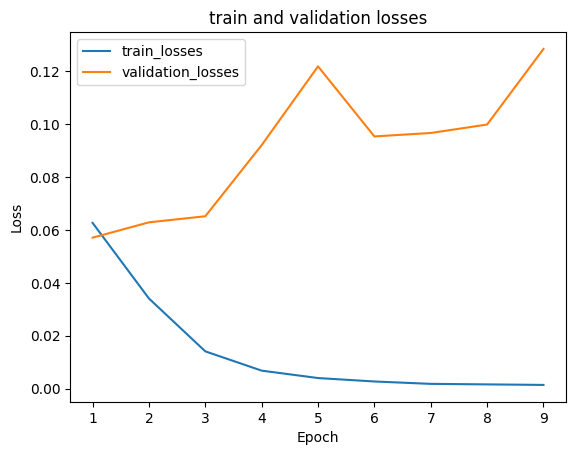

Some weights of ViTModel were not initialized from the model checkpoint at ./vit_model and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


正在训练第 2 折
--------------------------------


轮次 1/30: 100%|██████████| 50/50 [00:21<00:00,  2.35it/s]


轮次 1, 训练损失: 0.062


轮次 1/30: 100%|██████████| 13/13 [00:03<00:00,  4.17it/s]


验证损失: 0.0525, 准确率: 63.5%
验证准确率升高，保存当前模型


轮次 2/30: 100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


轮次 2, 训练损失: 0.0343


轮次 2/30: 100%|██████████| 13/13 [00:03<00:00,  4.11it/s]


验证损失: 0.0615, 准确率: 63.62%
验证准确率升高，保存当前模型


轮次 3/30: 100%|██████████| 50/50 [00:21<00:00,  2.30it/s]


轮次 3, 训练损失: 0.0165


轮次 3/30: 100%|██████████| 13/13 [00:03<00:00,  4.05it/s]


验证损失: 0.0921, 准确率: 63.5%
验证准确率未提升，未提升的 epoch 数：1


轮次 4/30: 100%|██████████| 50/50 [00:21<00:00,  2.35it/s]


轮次 4, 训练损失: 0.0107


轮次 4/30: 100%|██████████| 13/13 [00:03<00:00,  4.27it/s]


验证损失: 0.1046, 准确率: 63.38%
验证准确率未提升，未提升的 epoch 数：2


轮次 5/30: 100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


轮次 5, 训练损失: 0.0048


轮次 5/30: 100%|██████████| 13/13 [00:03<00:00,  4.12it/s]


验证损失: 0.1217, 准确率: 62.5%
验证准确率未提升，未提升的 epoch 数：3
早停触发
由于早停机制，提前结束训练，在第 5 个 epoch 停止。


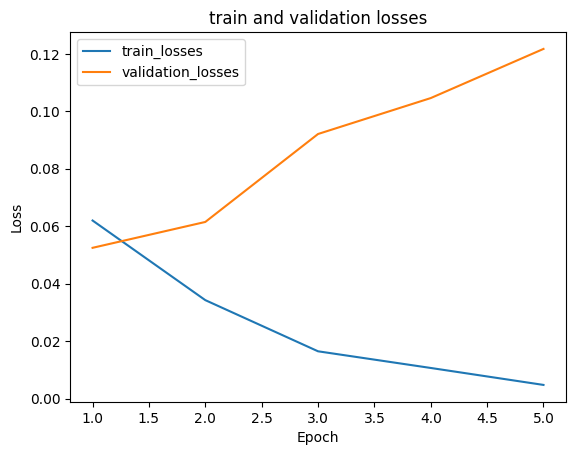

Some weights of ViTModel were not initialized from the model checkpoint at ./vit_model and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


正在训练第 3 折
--------------------------------


轮次 1/30: 100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


轮次 1, 训练损失: 0.061


轮次 1/30: 100%|██████████| 13/13 [00:03<00:00,  4.13it/s]


验证损失: 0.0492, 准确率: 67.62%
验证准确率升高，保存当前模型


轮次 2/30: 100%|██████████| 50/50 [00:21<00:00,  2.32it/s]


轮次 2, 训练损失: 0.0399


轮次 2/30: 100%|██████████| 13/13 [00:02<00:00,  4.36it/s]


验证损失: 0.0484, 准确率: 68.25%
验证准确率升高，保存当前模型


轮次 3/30: 100%|██████████| 50/50 [00:21<00:00,  2.38it/s]


轮次 3, 训练损失: 0.0229


轮次 3/30: 100%|██████████| 13/13 [00:03<00:00,  4.20it/s]


验证损失: 0.0572, 准确率: 68.12%
验证准确率未提升，未提升的 epoch 数：1


轮次 4/30: 100%|██████████| 50/50 [00:21<00:00,  2.35it/s]


轮次 4, 训练损失: 0.0087


轮次 4/30: 100%|██████████| 13/13 [00:03<00:00,  4.26it/s]


验证损失: 0.0865, 准确率: 70.0%
验证准确率升高，保存当前模型


轮次 5/30: 100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


轮次 5, 训练损失: 0.0058


轮次 5/30: 100%|██████████| 13/13 [00:03<00:00,  4.32it/s]


验证损失: 0.0951, 准确率: 69.62%
验证准确率未提升，未提升的 epoch 数：1


轮次 6/30: 100%|██████████| 50/50 [00:21<00:00,  2.37it/s]


轮次 6, 训练损失: 0.0042


轮次 6/30: 100%|██████████| 13/13 [00:03<00:00,  4.25it/s]


验证损失: 0.1008, 准确率: 69.12%
验证准确率未提升，未提升的 epoch 数：2


轮次 7/30: 100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


轮次 7, 训练损失: 0.0033


轮次 7/30: 100%|██████████| 13/13 [00:03<00:00,  4.29it/s]


验证损失: 0.1397, 准确率: 67.12%
验证准确率未提升，未提升的 epoch 数：3
早停触发
由于早停机制，提前结束训练，在第 7 个 epoch 停止。


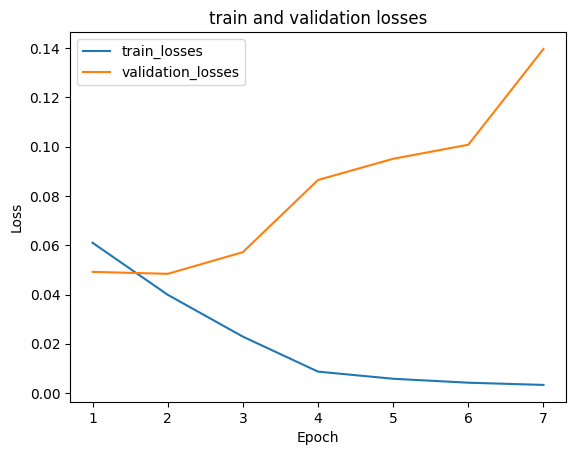

Some weights of ViTModel were not initialized from the model checkpoint at ./vit_model and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


正在训练第 4 折
--------------------------------


轮次 1/30: 100%|██████████| 50/50 [00:21<00:00,  2.37it/s]


轮次 1, 训练损失: 0.0594


轮次 1/30: 100%|██████████| 13/13 [00:03<00:00,  4.24it/s]


验证损失: 0.0494, 准确率: 66.5%
验证准确率升高，保存当前模型


轮次 2/30: 100%|██████████| 50/50 [00:21<00:00,  2.34it/s]


轮次 2, 训练损失: 0.0374


轮次 2/30: 100%|██████████| 13/13 [00:03<00:00,  4.12it/s]


验证损失: 0.0688, 准确率: 56.62%
验证准确率未提升，未提升的 epoch 数：1


轮次 3/30: 100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


轮次 3, 训练损失: 0.0197


轮次 3/30: 100%|██████████| 13/13 [00:03<00:00,  3.48it/s]


验证损失: 0.0947, 准确率: 63.5%
验证准确率未提升，未提升的 epoch 数：2


轮次 4/30: 100%|██████████| 50/50 [00:22<00:00,  2.27it/s]


轮次 4, 训练损失: 0.0086


轮次 4/30: 100%|██████████| 13/13 [00:03<00:00,  4.16it/s]


验证损失: 0.1088, 准确率: 64.38%
验证准确率未提升，未提升的 epoch 数：3
早停触发
由于早停机制，提前结束训练，在第 4 个 epoch 停止。


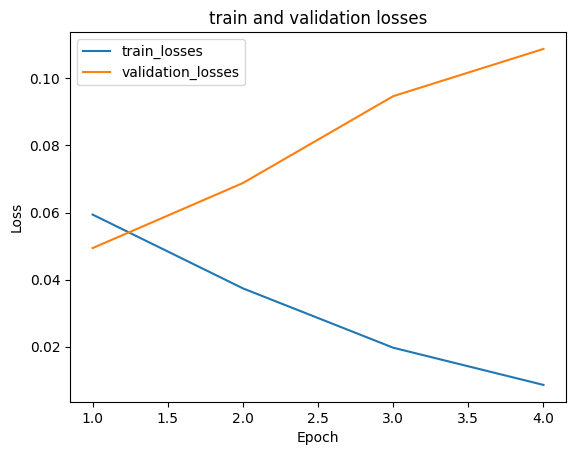

Some weights of ViTModel were not initialized from the model checkpoint at ./vit_model and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


正在训练第 5 折
--------------------------------


轮次 1/30: 100%|██████████| 50/50 [00:21<00:00,  2.34it/s]


轮次 1, 训练损失: 0.0634


轮次 1/30: 100%|██████████| 13/13 [00:03<00:00,  4.12it/s]


验证损失: 0.0481, 准确率: 65.5%
验证准确率升高，保存当前模型


轮次 2/30: 100%|██████████| 50/50 [00:21<00:00,  2.34it/s]


轮次 2, 训练损失: 0.035


轮次 2/30: 100%|██████████| 13/13 [00:03<00:00,  3.83it/s]


验证损失: 0.0487, 准确率: 70.75%
验证准确率升高，保存当前模型


轮次 3/30: 100%|██████████| 50/50 [00:21<00:00,  2.27it/s]


轮次 3, 训练损失: 0.0153


轮次 3/30: 100%|██████████| 13/13 [00:03<00:00,  4.29it/s]


验证损失: 0.0837, 准确率: 69.62%
验证准确率未提升，未提升的 epoch 数：1


轮次 4/30: 100%|██████████| 50/50 [00:21<00:00,  2.35it/s]


轮次 4, 训练损失: 0.0087


轮次 4/30: 100%|██████████| 13/13 [00:03<00:00,  4.24it/s]


验证损失: 0.0813, 准确率: 71.12%
验证准确率升高，保存当前模型


轮次 5/30: 100%|██████████| 50/50 [00:21<00:00,  2.33it/s]


轮次 5, 训练损失: 0.0059


轮次 5/30: 100%|██████████| 13/13 [00:03<00:00,  4.16it/s]


验证损失: 0.0867, 准确率: 73.12%
验证准确率升高，保存当前模型


轮次 6/30: 100%|██████████| 50/50 [00:21<00:00,  2.33it/s]


轮次 6, 训练损失: 0.0033


轮次 6/30: 100%|██████████| 13/13 [00:03<00:00,  4.18it/s]


验证损失: 0.0921, 准确率: 72.5%
验证准确率未提升，未提升的 epoch 数：1


轮次 7/30: 100%|██████████| 50/50 [00:21<00:00,  2.32it/s]


轮次 7, 训练损失: 0.0021


轮次 7/30: 100%|██████████| 13/13 [00:03<00:00,  4.09it/s]


验证损失: 0.1294, 准确率: 72.12%
验证准确率未提升，未提升的 epoch 数：2


轮次 8/30: 100%|██████████| 50/50 [00:21<00:00,  2.31it/s]


轮次 8, 训练损失: 0.0015


轮次 8/30: 100%|██████████| 13/13 [00:03<00:00,  4.06it/s]


验证损失: 0.119, 准确率: 71.0%
验证准确率未提升，未提升的 epoch 数：3
早停触发
由于早停机制，提前结束训练，在第 8 个 epoch 停止。


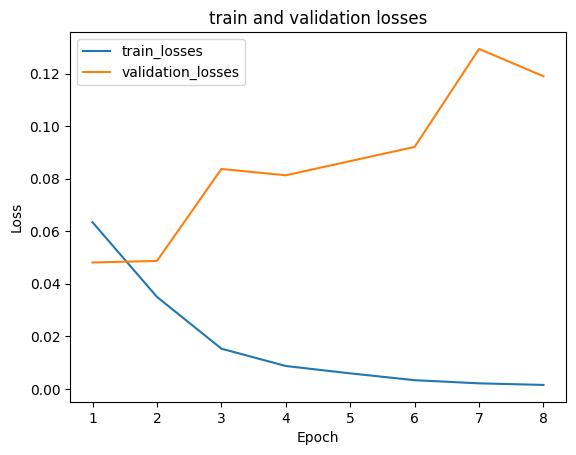

In [54]:
# resnet_feature_extractor = ResNet(
#     block=ResNetBlock, 
#     layers=[2, 2, 2, 2], 
#     feature_dim=512, 
#     dropout_prob= dropout_prob
# )

# # 2. 定义文本模型
# text_feature_extractor = Encoder(
#     vocab_size=vocab_size,     # 根据数据集大小来
#     d_model=512, 
#     nhead=8, 
#     num_layers=2, 
#     dim_feedforward=2048, 
#     dropout=dropout_prob, 
#     max_len=512
# )

# model = MultiModalModel_self(
#     image_model=resnet_feature_extractor,
#     text_model=text_feature_extractor,
#     d_model=512,
#     nhead=8,
#     dropout=dropout_prob 
# ).to(device)



k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=seed)

results = {}


for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
    print(f'正在训练第 {fold+1} 折')
    print('--------------------------------')

    resnet_feature_extractor = PretrainedViTExtractor()
    
    text_feature_extractor = BertTextEncoder(
        feature_dim=512,
        freeze_bert=True
    )

    model = MultiModalModel_pretrain(
        image_model=resnet_feature_extractor,
        text_model=text_feature_extractor,
        d_model=512,
        nhead = 8, 
        dropout=0.3
    ).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_subsampler = SubsetRandomSampler(train_idx)
    val_subsampler = SubsetRandomSampler(val_idx)

    # 数据加载器，将数据分批加载到模型中
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_subsampler)

    train_losses = []
    val_losses = []
    
    # 早停参数
    best_val_acc = 0
    epochs_no_improve = 0  
    early_stop = False  
    
    
    for epoch in range(num_epochs):
        # 训练模式
        model.train()
    
        total_train_loss = 0.0
    
        for batch in tqdm(train_loader, desc=f'轮次 {epoch+1}/{num_epochs}'):
            image = batch['image'].to(device)
            text = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].long().to(device)
    
            optimizer.zero_grad()   # 清空梯度
    
            outputs = model(image, text, attention_mask)
            labels_one_hot = F.one_hot(labels, num_classes=3).float()
            # loss = criterion(outputs, labels)
            loss = sigmoid_focal_loss(
                outputs,  # 模型的输出 (logits)，未经过 sigmoid
                labels_one_hot,  # 标签 (0 或 1)，与 inputs 的 shape 相同
                alpha=0.25,  # 平衡因子
                gamma=2.0,  # 调节因子
                reduction="mean"  # 'none', 'mean', or 'sum'
            )
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
    
            total_train_loss += loss.item()
    
        avg_train_loss = round(total_train_loss / len(train_loader), 4)
        train_losses.append(avg_train_loss)
        print(f'轮次 {epoch+1}, 训练损失: {avg_train_loss}')
    
    
        # 验证模式
        model.eval()
        
        val_loss = 0.0
        correct = 0
        total = 0
    
        with torch.no_grad():   # 不需要更新参数，禁用梯度计算
            for batch in tqdm(val_loader, desc=f'轮次 {epoch+1}/{num_epochs}'):
                image = batch['image'].to(device)
                text = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].long().to(device)
            
                outputs = model(image,text, attention_mask)
                labels_one_hot = F.one_hot(labels, num_classes=3).float()
                # loss = criterion(outputs, labels)
                loss = sigmoid_focal_loss(
                    outputs,  # 模型的输出 (logits)，未经过 sigmoid
                    labels_one_hot,  # 标签 (0 或 1)，与 inputs 的 shape 相同
                    alpha=0.25,  # 平衡因子
                    gamma=2.0,  # 调节因子
                    reduction="mean"  # 'none', 'mean', or 'sum'
                )
                val_loss += loss.item()
    
                _, predicted = torch.max(outputs.data, 1)   # 提取预测的类别索引
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
    
        avg_val_loss = round(val_loss / len(val_loader), 4)
        val_losses.append(avg_val_loss)
        val_acc = round(100 * correct / total, 2)
        print(f'验证损失: {avg_val_loss}, 准确率: {val_acc}%')
    
        # 早停机制
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
            file_path = os.path.join(model_path, f'best_model_fold_{fold}.pth')
            torch.save(model.state_dict(), file_path)
            print('验证准确率升高，保存当前模型')
        else:
            epochs_no_improve += 1
            print(f'验证准确率未提升，未提升的 epoch 数：{epochs_no_improve}')
    
        if epochs_no_improve >= patience:
            print('早停触发')
            early_stop = True
            break
    
    if early_stop:
        print(f'由于早停机制，提前结束训练，在第 {epoch+1} 个 epoch 停止。')
    else:
        print('训练完成')
    
    
    plt.figure()
    plt.plot(range(1, len(train_losses)+1), train_losses, label='train_losses')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='validation_losses')
    plt.title(f'train and validation losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    file_path = os.path.join(graph_path, f'loss_curve.png')
    plt.savefig(file_path)  # 保存图像
    plt.show()


In [75]:
print(torch.__version__)

2.5.1+cu124


In [ ]:
from transformers import BertModel

model = BertModel.from_pretrained('./bert_model1/')
print("BERT model loaded successfully!")


In [ ]:
train_size = int(0.8 * len(dataset))  # 80% 用于训练
val_size = len(dataset) - train_size   # 20% 用于验证
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(seed))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

轮次 1/30: 100%|██████████| 50/50 [00:12<00:00,  3.86it/s]


轮次 1, 训练损失: 0.0648


轮次 1/30: 100%|██████████| 13/13 [00:02<00:00,  5.48it/s]


验证损失: 0.0704, 准确率: 31.62%
验证准确率升高，保存当前模型


轮次 2/30: 100%|██████████| 50/50 [00:10<00:00,  4.73it/s]


轮次 2, 训练损失: 0.055


轮次 2/30: 100%|██████████| 13/13 [00:02<00:00,  5.77it/s]


验证损失: 0.0659, 准确率: 38.62%
验证准确率升高，保存当前模型


轮次 3/30: 100%|██████████| 50/50 [00:10<00:00,  4.77it/s]


轮次 3, 训练损失: 0.0541


轮次 3/30: 100%|██████████| 13/13 [00:02<00:00,  4.52it/s]


验证损失: 0.075, 准确率: 31.88%
验证准确率未提升，未提升的 epoch 数：1


轮次 4/30: 100%|██████████| 50/50 [00:12<00:00,  4.04it/s]


轮次 4, 训练损失: 0.0539


轮次 4/30: 100%|██████████| 13/13 [00:02<00:00,  5.39it/s]


验证损失: 0.0786, 准确率: 37.0%
验证准确率未提升，未提升的 epoch 数：2


轮次 5/30: 100%|██████████| 50/50 [00:10<00:00,  4.56it/s]


轮次 5, 训练损失: 0.0535


轮次 5/30: 100%|██████████| 13/13 [00:02<00:00,  5.54it/s]


验证损失: 0.0654, 准确率: 40.75%
验证准确率升高，保存当前模型


轮次 6/30: 100%|██████████| 50/50 [00:10<00:00,  4.60it/s]


轮次 6, 训练损失: 0.0527


轮次 6/30: 100%|██████████| 13/13 [00:02<00:00,  5.73it/s]


验证损失: 0.0614, 准确率: 40.38%
验证准确率未提升，未提升的 epoch 数：1


轮次 7/30: 100%|██████████| 50/50 [00:11<00:00,  4.40it/s]


轮次 7, 训练损失: 0.0523


轮次 7/30: 100%|██████████| 13/13 [00:02<00:00,  4.73it/s]


验证损失: 0.056, 准确率: 57.38%
验证准确率升高，保存当前模型


轮次 8/30: 100%|██████████| 50/50 [00:11<00:00,  4.44it/s]


轮次 8, 训练损失: 0.0517


轮次 8/30: 100%|██████████| 13/13 [00:02<00:00,  4.91it/s]


验证损失: 0.066, 准确率: 36.62%
验证准确率未提升，未提升的 epoch 数：1


轮次 9/30: 100%|██████████| 50/50 [00:12<00:00,  3.85it/s]


轮次 9, 训练损失: 0.0509


轮次 9/30: 100%|██████████| 13/13 [00:02<00:00,  5.24it/s]


验证损失: 0.0685, 准确率: 36.12%
验证准确率未提升，未提升的 epoch 数：2


轮次 10/30: 100%|██████████| 50/50 [00:12<00:00,  4.08it/s]


轮次 10, 训练损失: 0.0508


轮次 10/30: 100%|██████████| 13/13 [00:02<00:00,  5.48it/s]


验证损失: 0.0606, 准确率: 49.12%
验证准确率未提升，未提升的 epoch 数：3
早停触发
由于早停机制，提前结束训练，在第 10 个 epoch 停止。


轮次 1/30: 100%|██████████| 50/50 [00:10<00:00,  4.66it/s]


轮次 1, 训练损失: 0.0599


轮次 1/30: 100%|██████████| 13/13 [00:02<00:00,  5.53it/s]


验证损失: 0.071, 准确率: 55.75%
验证准确率升高，保存当前模型


轮次 2/30: 100%|██████████| 50/50 [00:10<00:00,  4.75it/s]


轮次 2, 训练损失: 0.0554


轮次 2/30: 100%|██████████| 13/13 [00:02<00:00,  5.85it/s]


验证损失: 0.0665, 准确率: 56.38%
验证准确率升高，保存当前模型


轮次 3/30: 100%|██████████| 50/50 [00:10<00:00,  4.79it/s]


轮次 3, 训练损失: 0.0546


轮次 3/30: 100%|██████████| 13/13 [00:02<00:00,  5.59it/s]


验证损失: 0.0599, 准确率: 55.12%
验证准确率未提升，未提升的 epoch 数：1


轮次 4/30: 100%|██████████| 50/50 [00:10<00:00,  4.69it/s]


轮次 4, 训练损失: 0.0535


轮次 4/30: 100%|██████████| 13/13 [00:02<00:00,  5.44it/s]


验证损失: 0.0738, 准确率: 49.88%
验证准确率未提升，未提升的 epoch 数：2


轮次 5/30: 100%|██████████| 50/50 [00:10<00:00,  4.66it/s]


轮次 5, 训练损失: 0.0521


轮次 5/30: 100%|██████████| 13/13 [00:02<00:00,  5.43it/s]


验证损失: 0.0737, 准确率: 48.88%
验证准确率未提升，未提升的 epoch 数：3
早停触发
由于早停机制，提前结束训练，在第 5 个 epoch 停止。


轮次 1/30: 100%|██████████| 50/50 [00:10<00:00,  4.69it/s]


轮次 1, 训练损失: 0.0601


轮次 1/30: 100%|██████████| 13/13 [00:02<00:00,  5.34it/s]


验证损失: 0.0637, 准确率: 45.0%
验证准确率升高，保存当前模型


轮次 2/30: 100%|██████████| 50/50 [00:11<00:00,  4.32it/s]


轮次 2, 训练损失: 0.0549


轮次 2/30: 100%|██████████| 13/13 [00:02<00:00,  5.65it/s]


验证损失: 0.0682, 准确率: 53.88%
验证准确率升高，保存当前模型


轮次 3/30: 100%|██████████| 50/50 [00:10<00:00,  4.78it/s]


轮次 3, 训练损失: 0.0522


轮次 3/30: 100%|██████████| 13/13 [00:02<00:00,  5.86it/s]


验证损失: 0.0744, 准确率: 57.75%
验证准确率升高，保存当前模型


轮次 4/30: 100%|██████████| 50/50 [00:10<00:00,  4.69it/s]


轮次 4, 训练损失: 0.0504


轮次 4/30: 100%|██████████| 13/13 [00:02<00:00,  5.54it/s]


验证损失: 0.0817, 准确率: 56.75%
验证准确率未提升，未提升的 epoch 数：1


轮次 5/30: 100%|██████████| 50/50 [00:10<00:00,  4.86it/s]


轮次 5, 训练损失: 0.0479


轮次 5/30: 100%|██████████| 13/13 [00:02<00:00,  5.87it/s]


验证损失: 0.0608, 准确率: 60.88%
验证准确率升高，保存当前模型


轮次 6/30: 100%|██████████| 50/50 [00:10<00:00,  4.75it/s]


轮次 6, 训练损失: 0.045


轮次 6/30: 100%|██████████| 13/13 [00:02<00:00,  5.62it/s]


验证损失: 0.0676, 准确率: 60.5%
验证准确率未提升，未提升的 epoch 数：1


轮次 7/30: 100%|██████████| 50/50 [00:10<00:00,  4.69it/s]


轮次 7, 训练损失: 0.0425


轮次 7/30: 100%|██████████| 13/13 [00:02<00:00,  5.63it/s]


验证损失: 0.0688, 准确率: 57.38%
验证准确率未提升，未提升的 epoch 数：2


轮次 8/30: 100%|██████████| 50/50 [00:10<00:00,  4.55it/s]


轮次 8, 训练损失: 0.0405


轮次 8/30: 100%|██████████| 13/13 [00:03<00:00,  3.92it/s]


验证损失: 0.0674, 准确率: 63.62%
验证准确率升高，保存当前模型


轮次 9/30: 100%|██████████| 50/50 [00:11<00:00,  4.47it/s]


轮次 9, 训练损失: 0.0382


轮次 9/30: 100%|██████████| 13/13 [00:02<00:00,  5.93it/s]


验证损失: 0.0718, 准确率: 60.25%
验证准确率未提升，未提升的 epoch 数：1


轮次 10/30: 100%|██████████| 50/50 [00:10<00:00,  4.74it/s]


轮次 10, 训练损失: 0.0362


轮次 10/30: 100%|██████████| 13/13 [00:02<00:00,  5.63it/s]


验证损失: 0.0722, 准确率: 63.12%
验证准确率未提升，未提升的 epoch 数：2


轮次 11/30: 100%|██████████| 50/50 [00:10<00:00,  4.65it/s]


轮次 11, 训练损失: 0.0349


轮次 11/30: 100%|██████████| 13/13 [00:02<00:00,  5.79it/s]


验证损失: 0.0773, 准确率: 62.5%
验证准确率未提升，未提升的 epoch 数：3
早停触发
由于早停机制，提前结束训练，在第 11 个 epoch 停止。


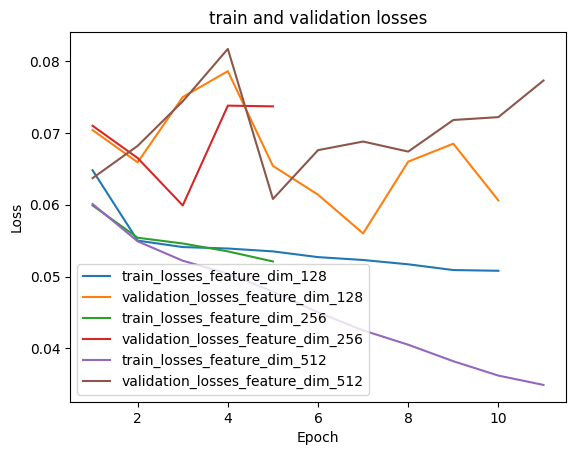

In [95]:
features = [128,256,512]
trains = []
vals = []
for feature in features:
    
    resnet_feature_extractor = ResNet(
        block=ResNetBlock, 
        layers=[2, 2, 2, 2], 
        feature_dim=feature, 
        dropout_prob= 0.3
    )
    
    # 2. 定义文本模型
    text_feature_extractor = Encoder(
        vocab_size=vocab_size,     # 根据数据集大小来
        d_model=feature, 
        nhead=8, 
        num_layers=2, 
        dim_feedforward=1024, 
        dropout=0.3, 
        max_len=512
    )
    
    model = MultiModalModel_self(
        image_model=resnet_feature_extractor,
        text_model=text_feature_extractor,
        d_model=feature,
        nhead=8,
        dropout=0.3
    ).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
        
    
    train_losses = []
    val_losses = []
    
    # 早停参数
    best_val_acc = 0
    epochs_no_improve = 0  
    early_stop = False  
    
        
    for epoch in range(num_epochs):
        # 训练模式
        model.train()
    
        total_train_loss = 0.0
    
        for batch in tqdm(train_loader, desc=f'轮次 {epoch+1}/{num_epochs}'):
            image = batch['image'].to(device)
            text = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].long().to(device)
    
            optimizer.zero_grad()   # 清空梯度
    
            outputs = model(image, text, attention_mask)
            labels_one_hot = F.one_hot(labels, num_classes=3).float()
            # loss = criterion(outputs, labels)
            loss = sigmoid_focal_loss(
                outputs,  # 模型的输出 (logits)，未经过 sigmoid
                labels_one_hot,  # 标签 (0 或 1)，与 inputs 的 shape 相同
                alpha=0.25,  # 平衡因子
                gamma=2.0,  # 调节因子
                reduction="mean"  # 'none', 'mean', or 'sum'
            )
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
    
            total_train_loss += loss.item()
    
        avg_train_loss = round(total_train_loss / len(train_loader), 4)
        train_losses.append(avg_train_loss)
        print(f'轮次 {epoch+1}, 训练损失: {avg_train_loss}')
    
    
        # 验证模式
        model.eval()
        
        val_loss = 0.0
        correct = 0
        total = 0
    
        with torch.no_grad():   # 不需要更新参数，禁用梯度计算
            for batch in tqdm(val_loader, desc=f'轮次 {epoch+1}/{num_epochs}'):
                image = batch['image'].to(device)
                text = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].long().to(device)
            
                outputs = model(image,text, attention_mask)
                labels_one_hot = F.one_hot(labels, num_classes=3).float()
                # loss = criterion(outputs, labels)
                loss = sigmoid_focal_loss(
                    outputs,  # 模型的输出 (logits)，未经过 sigmoid
                    labels_one_hot,  # 标签 (0 或 1)，与 inputs 的 shape 相同
                    alpha=0.25,  # 平衡因子
                    gamma=2.0,  # 调节因子
                    reduction="mean"  # 'none', 'mean', or 'sum'
                )
                val_loss += loss.item()
    
                _, predicted = torch.max(outputs.data, 1)   # 提取预测的类别索引
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
    
        avg_val_loss = round(val_loss / len(val_loader), 4)
        val_losses.append(avg_val_loss)
        val_acc = round(100 * correct / total, 2)
        print(f'验证损失: {avg_val_loss}, 准确率: {val_acc}%')
    
        # 早停机制
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
            file_path = os.path.join(model_path, f'best_model.pth')
            torch.save(model.state_dict(), file_path)
            print('验证准确率升高，保存当前模型')
        else:
            epochs_no_improve += 1
            print(f'验证准确率未提升，未提升的 epoch 数：{epochs_no_improve}')
    
        if epochs_no_improve >= patience:
            print('早停触发')
            early_stop = True
            break
    trains.append(train_losses)
    vals.append(val_losses)
            
    if early_stop:
        print(f'由于早停机制，提前结束训练，在第 {epoch+1} 个 epoch 停止。')
    else:
        print('训练完成')


plt.figure()
plt.plot(range(1, len(trains[0])+1), trains[0], label='train_losses_feature_dim_128')
plt.plot(range(1, len(vals[0])+1), vals[0], label='validation_losses_feature_dim_128')
plt.plot(range(1, len(trains[1])+1), trains[1], label='train_losses_feature_dim_256')
plt.plot(range(1, len(vals[1])+1), vals[1], label='validation_losses_feature_dim_256')
plt.plot(range(1, len(trains[2])+1), trains[2], label='train_losses_feature_dim_512')
plt.plot(range(1, len(vals[2])+1), vals[2], label='validation_losses_feature_dim_512')
plt.title(f'train and validation losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
file_path = os.path.join(graph_path, f'loss_curve.png')
plt.savefig(file_path)  # 保存图像
plt.show()


In [62]:
data_dir = "Data"
train_file = "test_without_label.txt"
dataset = load_data(data_dir, train_file)

df = pd.DataFrame(dataset)
print(df.head())
df['tokens'] = df['text'].apply(preprocess_text_for_w2v)

mapping = {
    'neutral': 1,
    'negative': 0,
    'positive': 2
}

df["tag_encoded"] = df["tag"].map(mapping)
dataset = SummarizationDataset(df, image_col='image', text_col='tokens', target_col='tag_encoded', transform=transform, tokenizer=tokenizer)

  guide                                              image  \
0     8  <PIL.Image.Image image mode=RGB size=599x447 a...   
1  1576  <PIL.Image.Image image mode=RGB size=600x424 a...   
2  2320  <PIL.Image.Image image mode=RGB size=444x360 a...   
3  4912  <PIL.Image.Image image mode=RGB size=600x600 a...   
4  3821  <PIL.Image.Image image mode=RGB size=599x399 a...   

                                                text   tag  
0  Energetic training today with our San Antonio ...  null  
1  Let your voice be heard! 18+ #endsuicide #blit...  null  
2  RT @Austin_Powers__: Shark Week would be so mu...  null  
3           #TheTruthCaster http://t.co/S8jvqpKq5h\n  null  
4  RT @jarpad: Hey #WBSDCC look what we're up to!...  null  


In [63]:
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

In [64]:
file_path = os.path.join(model_path, 'best_model_fold_4.pth')   
model.load_state_dict(torch.load(file_path))

/tmp/ipykernel_1364/917313103.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(file_path))


<All keys matched successfully>

In [ ]:
model.eval()

model.to(device)

# 3. 模型推理
all_preds = []

with torch.no_grad():   # 不需要更新参数，禁用梯度计算
    for batch in tqdm(dataloader, desc=f'轮次 {epoch+1}/{num_epochs}'):
        image = batch['image'].to(device)
        text = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].long().to(device)
    
        outputs = model(image,text, attention_mask)
        _, predicted = torch.max(outputs.data, 1)   # 提取预测的类别索引
        
        preds = predicted.cpu().numpy().tolist()
        all_preds.extend(preds)

id2label = {0: "negative", 1: "neutral", 2: "positive"}  # 举例
pred_labels = [id2label[p] for p in all_preds]

# 将 DataFrame 中 'tag' 列从 null 改为预测结果
df["tag"] = pred_labels  # 与 all_preds 对应
df_filtered = df[["guide", "tag"]]

# 5. 保存到文件(替换 null)
out_file = "test_with_pred.txt"
df_filtered.to_csv(out_file, index=False)

print(f"预测完成，结果已写入 {out_file}")

